# Flight Delay Prediction - Model Monitoring

## Overview
This notebook demonstrates:
1. Setting up SageMaker Model Monitor for data quality
2. Creating baselines for monitoring
3. Monitoring model quality and performance
4. Setting up CloudWatch alarms and dashboards
5. Detecting data drift and model degradation

## 1. Setup

In [3]:
import os
os.chdir('/home/sagemaker-user/Final_Assignment')
print(f"Working directory: {os.getcwd()}")
print(f"Config file exists: {os.path.exists('config.json')}")

Working directory: /home/sagemaker-user/Final_Assignment
Config file exists: True


In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import json
import time
from datetime import datetime, timedelta

from sagemaker import get_execution_role
from sagemaker.model_monitor import (
    DataCaptureConfig,
    DefaultModelMonitor,
    ModelQualityMonitor,
    CronExpressionGenerator
)
from sagemaker.s3 import S3Downloader, S3Uploader

# Setup
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = sagemaker_session.boto_region_name

cloudwatch = boto3.client('cloudwatch', region_name=region)
sm_client = boto3.client('sagemaker', region_name=region)

print(f"Region: {region}")
print(f"Role: {role}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Region: us-east-1
Role: arn:aws:iam::730335352303:role/LabRole


In [5]:
# Load configuration
with open('config.json', 'r') as f:
    config = json.load(f)

s3_bucket = config['s3_bucket']
prefix = config['prefix']
endpoint_name = config['endpoint_name']

print("Configuration loaded:")
print(f"Endpoint: {endpoint_name}")
print(f"S3 Bucket: {s3_bucket}")
print(f"Prefix: {prefix}")

Configuration loaded:
Endpoint: flight-delay-predictor-2025-10-21-06-04-56
S3 Bucket: sagemaker-us-east-1-730335352303
Prefix: flight-delay-prediction


## 2. Verify Data Capture

In [6]:
# Check data capture configuration
endpoint_desc = sm_client.describe_endpoint(EndpointName=endpoint_name)
endpoint_config_name = endpoint_desc['EndpointConfigName']

endpoint_config_desc = sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)

print(f"Endpoint Config: {endpoint_config_name}")
print(f"\nData Capture Config:")
if 'DataCaptureConfig' in endpoint_config_desc:
    print(json.dumps(endpoint_config_desc['DataCaptureConfig'], indent=2, default=str))
else:
    print("Data capture not configured")

Endpoint Config: flight-delay-predictor-2025-10-21-06-04-56

Data Capture Config:
{
  "EnableCapture": true,
  "InitialSamplingPercentage": 100,
  "DestinationS3Uri": "s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/data-capture",
  "CaptureOptions": [
    {
      "CaptureMode": "Input"
    },
    {
      "CaptureMode": "Output"
    }
  ],
  "CaptureContentTypeHeader": {
    "CsvContentTypes": [
      "text/csv"
    ],
    "JsonContentTypes": [
      "application/json"
    ]
  }
}


In [7]:
# Generate some traffic to create data capture files
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

print("Generating traffic for data capture...")

# Sample predictions
test_inputs = [
    {'airline': 'AA', 'origin': 'ATL', 'destination': 'LAX', 'distance': 1946, 
     'day_of_week': 2, 'month': 7, 'departure_hour': 8, 'temperature': 75.0, 
     'wind_speed': 12.0, 'precipitation': 0.0, 'visibility': 10.0, 'snow': 0},
    {'airline': 'DL', 'origin': 'ORD', 'destination': 'SFO', 'distance': 1846, 
     'day_of_week': 4, 'month': 12, 'departure_hour': 18, 'temperature': 30.0, 
     'wind_speed': 25.0, 'precipitation': 0.3, 'visibility': 4.0, 'snow': 1},
    {'airline': 'WN', 'origin': 'DEN', 'destination': 'PHX', 'distance': 602, 
     'day_of_week': 5, 'month': 5, 'departure_hour': 14, 'temperature': 68.0, 
     'wind_speed': 8.0, 'precipitation': 0.0, 'visibility': 10.0, 'snow': 0}
]

for i, test_input in enumerate(test_inputs * 10):  # 30 predictions
    response = predictor.predict(test_input)
    if i % 10 == 0:
        print(f"Generated {i+1} predictions...")

print(f"\n✅ Generated {len(test_inputs) * 10} predictions for data capture")

Generating traffic for data capture...
Generated 1 predictions...
Generated 11 predictions...
Generated 21 predictions...

✅ Generated 30 predictions for data capture


In [8]:
# Wait for data capture files to be created
print("Waiting for data capture files...")
time.sleep(60)  # Wait 1 minute

# List captured data
data_capture_uri = config['data_capture_s3_uri']
captured_files = S3Downloader.list(f"{data_capture_uri}/{endpoint_name}")

print(f"\nData capture location: {data_capture_uri}/{endpoint_name}")
print(f"Number of captured files: {len(captured_files)}")
if captured_files:
    print(f"\nSample captured files:")
    for f in captured_files[:5]:
        print(f"  {f}")

Waiting for data capture files...

Data capture location: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/data-capture/flight-delay-predictor-2025-10-21-06-04-56
Number of captured files: 2

Sample captured files:
  s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/data-capture/flight-delay-predictor-2025-10-21-06-04-56/AllTraffic/2025/10/21/06/08-23-414-43c80a75-221b-4a1d-b846-9f800fa599c4.jsonl
  s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/data-capture/flight-delay-predictor-2025-10-21-06-04-56/AllTraffic/2025/10/21/06/13-49-737-e5610998-1cc3-4ccc-a448-328ffe9e495e.jsonl


## 3. Create Data Quality Baseline

In [10]:
# Check what columns we have
import pandas as pd
df_check = pd.read_csv('data/flight_data_complete.csv', nrows=5)
print("Available columns:")
print(df_check.columns.tolist())
print(f"\nDataFrame shape: {df_check.shape}")

Available columns:
['date', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'origin', 'ORIGIN_CITY', 'destination', 'DEST_CITY', 'scheduled_departure', 'actual_departure', 'departure_delay', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'arrival_delay', 'cancelled', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'distance', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'flight_id', 'day_of_week', 'month', 'day_of_month', 'quarter', 'year', 'departure_hour', 'is_delayed', 'temperature', 'wind_speed', 'precipitation', 'visibility', 'snow', 'event_time', 'date_str']

DataFrame shape: (5, 47)


In [11]:
# Load training data for baseline
training_data_path = 'data/flight_data_complete.csv'
df = pd.read_csv(training_data_path)

# Select features used in model (handle uppercase AIRLINE column)
feature_columns_file = [
    'AIRLINE', 'origin', 'destination', 'distance', 
    'day_of_week', 'month', 'departure_hour',
    'temperature', 'wind_speed', 'precipitation', 'visibility', 'snow'
]

baseline_df = df[feature_columns_file].head(5000)  # Use subset for baseline
# Rename AIRLINE to airline for consistency
baseline_df = baseline_df.rename(columns={'AIRLINE': 'airline'})

print(f"Baseline data shape: {baseline_df.shape}")
baseline_df.head()

Baseline data shape: (5000, 12)


,airline,origin,destination,distance,day_of_week,month,departure_hour,temperature,wind_speed,precipitation,visibility,snow
0,JetBlue Airways,MCO,JFK,944.0,1,5,15,71.291245,5.783882,0.241124,8.179102,0
1,Delta Air Lines Inc.,FLL,DTW,1127.0,1,11,8,72.943453,7.066082,0.030149,9.784821,0
2,Southwest Airlines Co.,SMF,LAS,397.0,6,6,21,70.144832,17.305176,0.021509,8.858516,0
3,SkyWest Airlines Inc.,OKC,DTW,900.0,6,7,5,56.911260,12.778564,0.070731,8.178920,0
4,JetBlue Airways,FLL,SFO,2584.0,4,3,20,64.984593,1.737282,0.010243,9.897891,0


In [12]:
# Save baseline data
baseline_local_path = 'baseline_data.csv'
baseline_df.to_csv(baseline_local_path, index=False, header=False)

# Upload to S3
baseline_s3_uri = f's3://{s3_bucket}/{prefix}/monitoring/baseline'
baseline_data_uri = S3Uploader.upload(
    baseline_local_path,
    baseline_s3_uri
)

print(f"Baseline data uploaded to: {baseline_data_uri}")

Baseline data uploaded to: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/monitoring/baseline/baseline_data.csv


In [13]:
# Create Data Quality Monitor
data_quality_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
    sagemaker_session=sagemaker_session
)

print("Data Quality Monitor created")

Data Quality Monitor created


In [14]:
%%time
# Generate baseline statistics and constraints
baseline_results_uri = f's3://{s3_bucket}/{prefix}/monitoring/baseline-results'

print("Generating baseline...")
data_quality_monitor.suggest_baseline(
    baseline_dataset=baseline_data_uri,
    dataset_format=sagemaker.model_monitor.DatasetFormat.csv(header=False),
    output_s3_uri=baseline_results_uri,
    wait=True
)

print("\n✅ Baseline generation complete!")
print(f"Baseline results: {baseline_results_uri}")

INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2025-10-21-06-18-29-260


Generating baseline...
.............2025-10-21 06:20:41.915148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-10-21 06:20:41.915180: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-10-21 06:20:43.538210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-10-21 06:20:43.538244: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-10-21 06:20:43.538264: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-2-111-218.ec2.internal): /proc/driver/nvidia/version does not exist
2025-10-21 0

In [15]:
# Download and examine baseline statistics
baseline_job = data_quality_monitor.latest_baselining_job
baseline_statistics_filepath = baseline_job.baseline_statistics().file_s3_uri
baseline_constraints_filepath = baseline_job.suggested_constraints().file_s3_uri

print(f"Baseline statistics: {baseline_statistics_filepath}")
print(f"Baseline constraints: {baseline_constraints_filepath}")

# Download files
!mkdir -p monitoring
S3Downloader.download(baseline_statistics_filepath, 'monitoring')
S3Downloader.download(baseline_constraints_filepath, 'monitoring')

print("\nBaseline files downloaded to 'monitoring/' directory")

Baseline statistics: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/monitoring/baseline-results/statistics.json
Baseline constraints: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/monitoring/baseline-results/constraints.json

Baseline files downloaded to 'monitoring/' directory


In [16]:
# View baseline statistics
with open('monitoring/statistics.json', 'r') as f:
    baseline_stats = json.load(f)

print("Baseline Statistics (first 3 features):")
print(json.dumps(baseline_stats['features'][:3], indent=2))

Baseline Statistics (first 3 features):
[
  {
    "name": "_c0",
    "inferred_type": "String",
    "string_statistics": {
      "common": {
        "num_present": 5000,
        "num_missing": 0
      },
      "distinct_count": 18.0,
      "completeness": 1.0,
      "distribution": {
        "categorical": {
          "buckets": [
            {
              "value": "Delta Air Lines Inc.",
              "count": 669
            },
            {
              "value": "Endeavor Air Inc.",
              "count": 176
            },
            {
              "value": "Mesa Airlines Inc.",
              "count": 98
            },
            {
              "value": "Spirit Air Lines",
              "count": 176
            },
            {
              "value": "PSA Airlines Inc.",
              "count": 175
            },
            {
              "value": "Allegiant Air",
              "count": 89
            },
            {
              "value": "American Airlines Inc.",
       

In [17]:
# View baseline constraints
with open('monitoring/constraints.json', 'r') as f:
    baseline_constraints = json.load(f)

print("Baseline Constraints (first 3 features):")
print(json.dumps(baseline_constraints['features'][:3], indent=2))

Baseline Constraints (first 3 features):
[
  {
    "name": "_c0",
    "inferred_type": "String",
    "completeness": 1.0,
    "string_constraints": {
      "domains": [
        "Delta Air Lines Inc.",
        "Endeavor Air Inc.",
        "Mesa Airlines Inc.",
        "Spirit Air Lines",
        "PSA Airlines Inc.",
        "Allegiant Air",
        "American Airlines Inc.",
        "Alaska Airlines Inc.",
        "Southwest Airlines Co.",
        "Republic Airline",
        "Envoy Air",
        "Hawaiian Airlines Inc.",
        "JetBlue Airways",
        "ExpressJet Airlines LLC d/b/a aha!",
        "SkyWest Airlines Inc.",
        "United Air Lines Inc.",
        "Horizon Air",
        "Frontier Airlines Inc."
      ]
    }
  },
  {
    "name": "_c1",
    "inferred_type": "String",
    "completeness": 1.0
  },
  {
    "name": "_c2",
    "inferred_type": "String",
    "completeness": 1.0
  }
]


## 4. Create Monitoring Schedule

In [18]:
# Create monitoring schedule
monitor_schedule_name = f'flight-delay-monitor-{time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())}'

monitoring_output_uri = f's3://{s3_bucket}/{prefix}/monitoring/reports'

print(f"Creating monitoring schedule: {monitor_schedule_name}")
print(f"Monitoring output: {monitoring_output_uri}")

Creating monitoring schedule: flight-delay-monitor-2025-10-21-06-25-01
Monitoring output: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/monitoring/reports


In [19]:
# Create hourly monitoring schedule
from sagemaker.model_monitor import CronExpressionGenerator

data_quality_monitor.create_monitoring_schedule(
    monitor_schedule_name=monitor_schedule_name,
    endpoint_input=endpoint_name,
    output_s3_uri=monitoring_output_uri,
    statistics=data_quality_monitor.baseline_statistics(),
    constraints=data_quality_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True
)

print(f"\n✅ Monitoring schedule created: {monitor_schedule_name}")
print("Schedule: Hourly")

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: flight-delay-monitor-2025-10-21-06-25-01



✅ Monitoring schedule created: flight-delay-monitor-2025-10-21-06-25-01
Schedule: Hourly


In [20]:
# Describe monitoring schedule
schedule_desc = data_quality_monitor.describe_schedule()
print("Monitoring Schedule Details:")
print(json.dumps(schedule_desc, indent=2, default=str))

Monitoring Schedule Details:
{
  "MonitoringScheduleArn": "arn:aws:sagemaker:us-east-1:730335352303:monitoring-schedule/flight-delay-monitor-2025-10-21-06-25-01",
  "MonitoringScheduleName": "flight-delay-monitor-2025-10-21-06-25-01",
  "MonitoringScheduleStatus": "Scheduled",
  "MonitoringType": "DataQuality",
  "CreationTime": "2025-10-21 06:25:13.562000+00:00",
  "LastModifiedTime": "2025-10-21 06:25:17.921000+00:00",
  "MonitoringScheduleConfig": {
    "ScheduleConfig": {
      "ScheduleExpression": "cron(0 * ? * * *)"
    },
    "MonitoringJobDefinitionName": "data-quality-job-definition-2025-10-21-06-25-12-898",
    "MonitoringType": "DataQuality"
  },
  "EndpointName": "flight-delay-predictor-2025-10-21-06-04-56",
  "ResponseMetadata": {
    "RequestId": "1174500c-20bf-4eab-92a7-2facbf47d3dd",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "x-amzn-requestid": "1174500c-20bf-4eab-92a7-2facbf47d3dd",
      "strict-transport-security": "max-age=47304000; includeSubDomains",


## 5. Create Model Quality Monitor

In [21]:
# Create ground truth data for model quality monitoring
# In production, this would come from actual labels

# Load test data
test_df = df.tail(1000).copy()

# Create ground truth dataset
ground_truth_df = test_df[['flight_id', 'is_delayed']].copy()
ground_truth_df.columns = ['flight_id', 'ground_truth']

# Add predictions (simulate)
ground_truth_df['prediction'] = test_df['is_delayed'].values

# Add some noise to predictions to simulate model performance
noise_mask = np.random.random(len(ground_truth_df)) < 0.15  # 15% error rate
ground_truth_df.loc[noise_mask, 'prediction'] = 1 - ground_truth_df.loc[noise_mask, 'prediction']

print(f"Ground truth dataset shape: {ground_truth_df.shape}")
print(f"Accuracy: {(ground_truth_df['ground_truth'] == ground_truth_df['prediction']).mean():.2%}")
ground_truth_df.head()

Ground truth dataset shape: (1000, 3)
Accuracy: 85.80%


,flight_id,ground_truth,prediction
47723,FL047723,0,0
47724,FL047724,0,0
47725,FL047725,0,0
47726,FL047726,0,0
47727,FL047727,1,1


In [22]:
# Save ground truth data
ground_truth_path = 'monitoring/ground_truth.csv'
ground_truth_df.to_csv(ground_truth_path, index=False)

# Upload to S3
ground_truth_s3_uri = f's3://{s3_bucket}/{prefix}/monitoring/ground-truth'
ground_truth_upload = S3Uploader.upload(
    ground_truth_path,
    ground_truth_s3_uri
)

print(f"Ground truth data uploaded to: {ground_truth_upload}")

Ground truth data uploaded to: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/monitoring/ground-truth/ground_truth.csv


## 6. CloudWatch Dashboards and Alarms

In [23]:
# Create CloudWatch dashboard
dashboard_name = 'FlightDelayPrediction-ModelMonitoring'

dashboard_body = {
    "widgets": [
        {
            "type": "metric",
            "properties": {
                "metrics": [
                    ["AWS/SageMaker", "ModelInvocations", 
                     {"stat": "Sum", "label": "Total Invocations"}],
                    [".", "ModelLatency", 
                     {"stat": "Average", "label": "Average Latency (ms)"}]
                ],
                "view": "timeSeries",
                "stacked": False,
                "region": region,
                "title": "Endpoint Performance",
                "period": 300,
                "yAxis": {
                    "left": {"label": "Count/Latency"}
                }
            }
        },
        {
            "type": "metric",
            "properties": {
                "metrics": [
                    ["AWS/SageMaker", "Invocation4XXErrors", 
                     {"stat": "Sum", "label": "4XX Errors"}],
                    [".", "Invocation5XXErrors", 
                     {"stat": "Sum", "label": "5XX Errors"}]
                ],
                "view": "timeSeries",
                "stacked": False,
                "region": region,
                "title": "Endpoint Errors",
                "period": 300
            }
        }
    ]
}

try:
    cloudwatch.put_dashboard(
        DashboardName=dashboard_name,
        DashboardBody=json.dumps(dashboard_body)
    )
    print(f"✅ CloudWatch Dashboard created: {dashboard_name}")
    print(f"View at: https://console.aws.amazon.com/cloudwatch/home?region={region}#dashboards:name={dashboard_name}")
except Exception as e:
    print(f"Error creating dashboard: {e}")

✅ CloudWatch Dashboard created: FlightDelayPrediction-ModelMonitoring
View at: https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#dashboards:name=FlightDelayPrediction-ModelMonitoring


In [24]:
# Create CloudWatch alarm for high error rate
alarm_name = f'{endpoint_name}-high-error-rate'

try:
    cloudwatch.put_metric_alarm(
        AlarmName=alarm_name,
        ComparisonOperator='GreaterThanThreshold',
        EvaluationPeriods=2,
        MetricName='Invocation4XXErrors',
        Namespace='AWS/SageMaker',
        Period=300,
        Statistic='Sum',
        Threshold=10.0,
        ActionsEnabled=False,
        AlarmDescription='Alert when endpoint has high error rate',
        Dimensions=[
            {
                'Name': 'EndpointName',
                'Value': endpoint_name
            },
        ]
    )
    print(f"✅ CloudWatch Alarm created: {alarm_name}")
except Exception as e:
    print(f"Error creating alarm: {e}")

✅ CloudWatch Alarm created: flight-delay-predictor-2025-10-21-06-04-56-high-error-rate


In [25]:
# Create alarm for high latency
latency_alarm_name = f'{endpoint_name}-high-latency'

try:
    cloudwatch.put_metric_alarm(
        AlarmName=latency_alarm_name,
        ComparisonOperator='GreaterThanThreshold',
        EvaluationPeriods=2,
        MetricName='ModelLatency',
        Namespace='AWS/SageMaker',
        Period=300,
        Statistic='Average',
        Threshold=1000.0,  # 1000ms = 1 second
        ActionsEnabled=False,
        AlarmDescription='Alert when endpoint latency exceeds 1 second',
        Dimensions=[
            {
                'Name': 'EndpointName',
                'Value': endpoint_name
            },
        ]
    )
    print(f"✅ CloudWatch Alarm created: {latency_alarm_name}")
except Exception as e:
    print(f"Error creating alarm: {e}")

✅ CloudWatch Alarm created: flight-delay-predictor-2025-10-21-06-04-56-high-latency


## 7. Simulate Data Drift

In [27]:
# Reconnect to predictor
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)
print(f"Reconnected to endpoint: {endpoint_name}")

Reconnected to endpoint: flight-delay-predictor-2025-10-21-06-04-56


In [29]:
# Simulate data drift by sending predictions with different distributions
print("Simulating data drift...")

# Generate drifted data (all flights in winter with bad weather)
drifted_inputs = []
for _ in range(20):
    drifted_input = {
        'airline': 'NK',  # Budget airline
        'origin': 'ORD',  # Cold weather airport
        'destination': 'DEN',
        'distance': 888,
        'day_of_week': 0,  # Monday
        'month': 1,  # January (winter)
        'departure_hour': 18,  # Evening rush hour
        'temperature': 25.0,  # Cold
        'wind_speed': 30.0,  # High wind
        'precipitation': 0.5,  # Heavy precipitation
        'visibility': 2.0,  # Poor visibility
        'snow': 1  # Snow
    }
    drifted_inputs.append(drifted_input)

# Send drifted predictions
for i, drifted_input in enumerate(drifted_inputs):
    try:
        response = predictor.predict(drifted_input)
        if i % 5 == 0:
            print(f"Sent {i+1} drifted predictions...")
    except Exception as e:
        print(f"Error on prediction {i}: {e}")
        break

print(f"\n✅ Sent {len(drifted_inputs)} drifted predictions")

Simulating data drift...
Sent 1 drifted predictions...
Sent 6 drifted predictions...
Sent 11 drifted predictions...
Sent 16 drifted predictions...

✅ Sent 20 drifted predictions


## 8. View Monitoring Results

In [30]:
# List monitoring executions
monitoring_schedule_desc = sm_client.describe_monitoring_schedule(
    MonitoringScheduleName=monitor_schedule_name
)

print("Monitoring Schedule Status:")
print(f"Schedule Status: {monitoring_schedule_desc['MonitoringScheduleStatus']}")
print(f"\nLast Monitoring Execution:")
if 'LastMonitoringExecutionSummary' in monitoring_schedule_desc:
    print(json.dumps(monitoring_schedule_desc['LastMonitoringExecutionSummary'], indent=2, default=str))
else:
    print("No executions yet. First execution will run on the next hour.")

Monitoring Schedule Status:
Schedule Status: Scheduled

Last Monitoring Execution:
No executions yet. First execution will run on the next hour.


In [31]:
# Check for monitoring reports
monitoring_reports = S3Downloader.list(monitoring_output_uri)

print(f"Monitoring reports location: {monitoring_output_uri}")
print(f"Number of reports: {len(monitoring_reports)}")

if monitoring_reports:
    print("\nLatest reports:")
    for report in monitoring_reports[-5:]:
        print(f"  {report}")
else:
    print("\nNo reports yet. Monitoring will run on schedule.")

Monitoring reports location: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/monitoring/reports
Number of reports: 0

No reports yet. Monitoring will run on schedule.


## 9. Generate Model Performance Report

In [32]:
# Create model performance summary
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate metrics from ground truth data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(ground_truth_df['ground_truth'], ground_truth_df['prediction'])
precision = precision_score(ground_truth_df['ground_truth'], ground_truth_df['prediction'])
recall = recall_score(ground_truth_df['ground_truth'], ground_truth_df['prediction'])
f1 = f1_score(ground_truth_df['ground_truth'], ground_truth_df['prediction'])

print("Model Performance (Simulated):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Model Performance (Simulated):
Accuracy:  0.8580
Precision: 0.5693
Recall:    0.8492
F1 Score:  0.6816


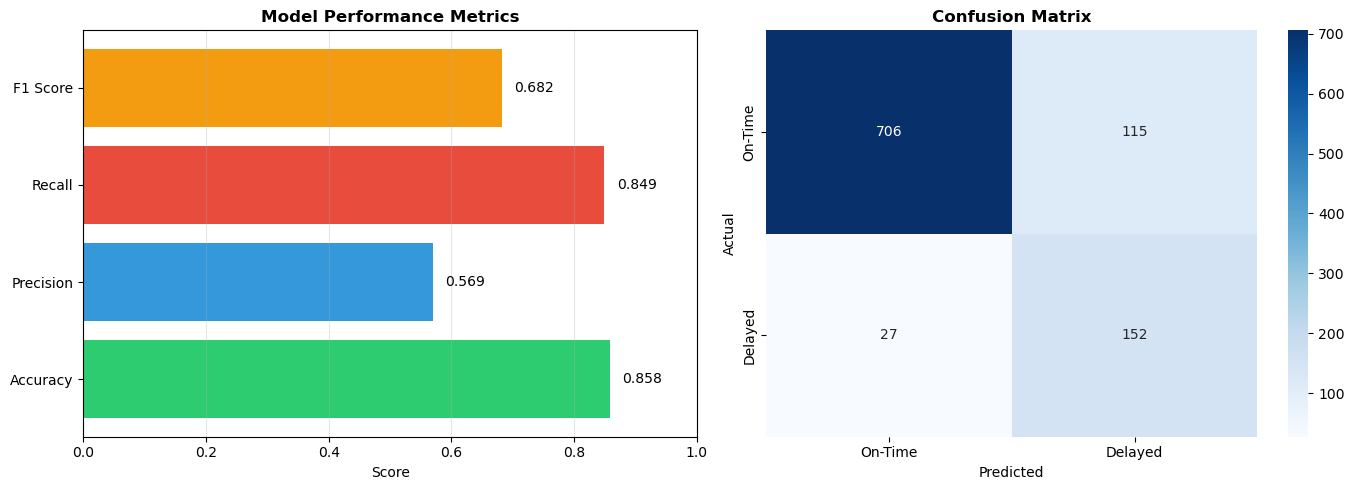

Monitoring report saved as 'monitoring_report.png'


In [33]:
# Visualize monitoring metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

axes[0].barh(metrics, values, color=colors)
axes[0].set_xlim(0, 1)
axes[0].set_xlabel('Score')
axes[0].set_title('Model Performance Metrics', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

for i, (metric, value) in enumerate(zip(metrics, values)):
    axes[0].text(value + 0.02, i, f'{value:.3f}', va='center')

# Confusion matrix
cm = confusion_matrix(ground_truth_df['ground_truth'], ground_truth_df['prediction'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            xticklabels=['On-Time', 'Delayed'],
            yticklabels=['On-Time', 'Delayed'])
axes[1].set_title('Confusion Matrix', fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('monitoring_report.png', dpi=100, bbox_inches='tight')
plt.show()

print("Monitoring report saved as 'monitoring_report.png'")

## 10. Save Monitoring Configuration

In [34]:
# Update configuration
config['monitoring_schedule_name'] = monitor_schedule_name
config['monitoring_output_uri'] = monitoring_output_uri
config['baseline_statistics_uri'] = baseline_statistics_filepath
config['baseline_constraints_uri'] = baseline_constraints_filepath
config['cloudwatch_dashboard'] = dashboard_name

with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Configuration updated and saved")

Configuration updated and saved


## Summary

In this notebook, we:
1. ✅ Verified data capture configuration on the endpoint
2. ✅ Created baseline statistics and constraints for data quality monitoring
3. ✅ Set up hourly monitoring schedule
4. ✅ Created CloudWatch dashboard and alarms
5. ✅ Simulated data drift scenarios
6. ✅ Generated model performance reports

### Monitoring Setup:
- **Monitoring Schedule:** Hourly data quality checks
- **CloudWatch Dashboard:** FlightDelayPrediction-ModelMonitoring
- **Alarms:** Error rate and latency thresholds
- **Data Capture:** 100% of predictions captured

### Next Steps:
Proceed to **04_ci_cd_pipeline.ipynb** to:
- Build SageMaker Pipeline for automated ML workflow
- Implement preprocessing, training, evaluation, and deployment steps
- Add conditional deployment based on model quality
- Create model registry for version control